# Data Analysis

Approach:

    Preprocess Images: Convert them to grayscale, normalize, and subtract the baseline from the active image.
    Segment Active Regions: Use OpenCV or a deep learning model to detect the highlighted brain regions.
    Identify the Region: Use a pre-trained model (e.g., a convolutional neural network trained on brain MRI scans) or a simple region-based lookup to determine which part of the brain is active.
    Overlay Annotations: Draw text labels or bounding boxes on the image.

## Imports, Settings, & Function Definitions

In [41]:
from moviepy import VideoFileClip
import librosa
from IPython.display import Audio as IPDAudio
from IPython.display import display, Image, Video
from transformers import pipeline
from datasets import Audio as Datasets_Audio
from datasets import Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.metrics import accuracy_score
import cv2
import time
from glob import glob
import os
import mediapipe as mp
from torch.utils.data import Dataset, DataLoader
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as tv_datasets
import torchvision.models as models

from PIL import Image as PIL_Image
import shutil

In [22]:
def extract_audio_from_video(video_file_path, audio_output_path):
    """
    This function will accept a video file path and output
    the extracted audio.

    Parameters
    ----------
    video_file_path : string
        This is the path to the mp4 video.
    audio_output_path : string
        This is the path to the output audio wav file.
    """
    video = VideoFileClip(video_file_path)
    audio = video.audio
    audio.write_audiofile(audio_output_path)

## Data Collection

In [3]:
# Total Video
video_file_path = '../data/kernel-brain-data-jokes-lex-only-training-set.mp4'
audio_file_path = '../data/kernel-brain-data-jokes-lex-only-training-set.wav'

# Laughter Training Samples
video_file_path_laughter_train = '../data/laughter-only/kernel-brain-data-jokes-lex-only-train-laughter-only.mp4'
audio_file_path_laughter_train = '../data/laughter-only/kernel-brain-data-jokes-lex-only-train-laughter-only.wav'

# Non-Laughter Training Samples
video_file_path_non_laughter_train = '../data/non-laughter/kernel-brain-data-jokes-lex-only-training-set-non-laughter.mp4'
audio_file_path_non_laughter_train = '../data/non-laughter/kernel-brain-data-jokes-lex-only-training-set-non-laughter.wav'

# All Frames
# laughter_all_frames = np.load('../data/laughter-only/laughter_all_frames.npy')
# non_laughter_all_frames = np.load('../data/non-laughter/non_laughter_all_frames.npy')

# Separated aughter Only
lex_human_laughter_only_np = np.load('../data/laughter-only/lex_human_laughter_only.npy')
lex_brain_laughter_only_np = np.load("../data/laughter-only/lex_brain_laughter_only.npy")

# Separated Non-Laughter
lex_human_non_laughter_np = np.load('../data/non-laughter/lex_human_non_laughter.npy')
lex_brain_non_laughter_np = np.load('../data/non-laughter/lex_brain_non_laughter.npy')

### Total Video Preprocessing

In [ ]:
audio_data, sample_rate = librosa.load(audio_file_path)
IPDAudio(data=audio_data, rate=sample_rate)

In [ ]:
Video(video_file_path)

In [ ]:
cap = cv2.VideoCapture(video_file_path)

In [ ]:
# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [ ]:
# Extract one frame per second
frames = []
for sec in tqdm(range(duration), desc="Extracting one frame per second...", ascii="░▒▓█"):
    cap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)  # Move to the timestamp (sec * 1000ms)
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    frames.append(frame)

cap.release()  # Release the video file


##### Insufficient memory to extract all frames

In [ ]:
# # Insufficient memory to extract all frames
# all_frames = []
# progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     # all_frames.append(frame)
#     progress_bar.update(1)
# cap.release()
# cv2.destroyAllWindows()
# progress_bar.close()

In [ ]:
index = 0

In [ ]:
# View all frames
index += 1 
index = index % len(frames)

plt.figure(figsize=(12, 8))
plt.imshow(frames[index])
plt.axis('off')
plt.tight_layout()
plt.show()
index

## Laughter Samples

### Sample Extraction

In [ ]:
cap = cv2.VideoCapture(video_file_path_laughter_train)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [ ]:
total_frames

In [ ]:
laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

In [ ]:
audio_data, sample_rate = librosa.load(audio_file_path_laughter_train)
IPDAudio(data=audio_data, rate=sample_rate)

### Extracting the Neural Data Frame

In [ ]:
index = 0

In [ ]:
index += 1
index %= len(laughter_all_frames)
plt.imshow(cv2.cvtColor(laughter_all_frames[index], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
index 

In [ ]:
laughter_all_frames[index].shape

In [ ]:
lex_brain_regions = {"lex_brain_y_t":600}
lex_brain_regions["lex_brain_y_b"] = 1400
lex_brain_regions["lex_brain_x_l"] = 1900
lex_brain_regions["lex_brain_x_r"] = 2950

In [ ]:
lex_human_regions = {}
lex_human_regions["lex_human_y_t"] = 0
lex_human_regions["lex_human_y_b"] = 1440
lex_human_regions["lex_human_x_l"] = 500
lex_human_regions["lex_human_x_r"] = 1800


In [ ]:
plt.imshow(laughter_all_frames[0][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])

In [ ]:
# Collect Lex Human Laughter Only
lex_human_laughter_only = []
for frame in tqdm(range(len(laughter_all_frames)), desc="Extracting Lex Only Laughter Frames...", ascii="░▒▓█"):
    lex_human_laughter_only.append(laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_laughter_only_np = np.array(lex_human_laughter_only)

In [ ]:
np.save('../data/laughter-only/lex_human_laughter_only.npy', lex_human_laughter_only_np)

In [ ]:
plt.imshow(laughter_all_frames[0][600:1400, 1900:2950, :])

In [ ]:
# Collect Lex Brain Laughter Only
lex_brain_laughter_only = []
for frame in tqdm(range(len(laughter_all_frames)), desc="Extracting Brain Only Laughter Frames...", ascii="░▒▓█"):
    lex_brain_laughter_only.append(laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_laughter_only_np = np.array(lex_brain_laughter_only)
np.save("../data/laughter-only/lex_brain_laughter_only.npy", lex_brain_laughter_only_np)

## Non-Laughter Samples

### Sample Extraction

In [ ]:
video_file_path_non_laughter_train

In [ ]:
audio_data, sample_rate = librosa.load(audio_file_path_non_laughter_train)
IPDAudio(data=audio_data, rate=sample_rate)

In [ ]:
cap = cv2.VideoCapture(video_file_path_non_laughter_train)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds
total_frames

In [ ]:
non_laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    non_laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

In [ ]:
# np.save('../data/non-laughter/non_laughter_all_frames.npy', np.array(non_laughter_all_frames))

In [ ]:
len(laughter_all_frames)

In [ ]:
len(non_laughter_all_frames)

### Extracting the Neural Data Frame (Non-Laughter)

In [ ]:
# Collect Lex Human Non Laughter
lex_human_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Frames...", ascii="░▒▓█"):
    lex_human_non_laughter.append(non_laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_non_laughter_np = np.array(lex_human_non_laughter)
np.save('../data/non-laughter/lex_human_non_laughter.npy', lex_human_non_laughter_np)

In [ ]:
lex_brain_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Brain Frames...", ascii="░▒▓█"):
    lex_brain_non_laughter.append(non_laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_non_laughter_np = np.array(lex_brain_non_laughter)
np.save('../data/non-laughter/lex_brain_non_laughter.npy', lex_brain_non_laughter_np)


## Creating Datasets

In [ ]:
# # Creating Brain Dataset Laughter
# f_dir = '../data/laughter-only/brain/'
# for index in tqdm(range(len(lex_brain_laughter_only_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_brain_laughter_only_{index}.png"
#     PIL_Image.fromarray(lex_brain_laughter_only_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 279/279 [00:24<00:00, 11.43it/s]


In [ ]:
# # Creating Brain Dataset Non-Laughter
# f_dir = '../data/non-laughter/brain/'
# for index in tqdm(range(len(lex_brain_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_brain_non_laughter_{index}.png"
#     PIL_Image.fromarray(lex_brain_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 339/339 [00:27<00:00, 12.43it/s]


In [ ]:
# # Creating Human Dataset Laughter
# f_dir = '../data/laughter-only/human/'
# for index in tqdm(range(len(lex_human_laughter_only_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_human_laughter_only_{index}.png"
#     PIL_Image.fromarray(lex_human_laughter_only_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 279/279 [00:42<00:00,  6.57it/s]


In [ ]:
# # Creating Human Dataset Non-Laughter
# f_dir = '../data/non-laughter/human/'
# for index in tqdm(range(len(lex_human_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_human_non_laughter_{index}.png"
#     PIL_Image.fromarray(lex_human_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 339/339 [00:46<00:00,  7.27it/s]


In [ ]:
# # Collecting audio lecture segments
# smile_data_dir = '../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/'
# non_laughter_audio_segment_file_paths = glob(smile_data_dir + "*_*_*")
# single_underscore_file_candidates = glob(smile_data_dir + '*_*')
# laughter_only_audio_segment_file_paths = [file for file in single_underscore_file_candidates if os.path.basename(file).count('_') == 1]

In [ ]:
# len(laughter_only_audio_segment_file_paths)

2546

In [ ]:
# len(non_laughter_audio_segment_file_paths)

1936

In [ ]:
# destination_folder_laughter = '../data/laughter-only/audio/'
# destination_folder_non_laughter = '../data/non-laughter/audio/'

In [ ]:
# for file_path in tqdm(non_laughter_audio_segment_file_paths, desc="Copying non-laughter audio segments...", ascii="░▒▓█"):
#     # Get the filename from the file path
#     filename = os.path.basename(file_path)
    
#     # Construct the destination file path
#     destination_path = os.path.join(destination_folder_non_laughter, filename)
    
#     # Copy the file to the destination folder
#     shutil.copy(file_path, destination_path)
    
#     print(f"Copied {file_path} to {destination_path}")

Copying non-laughter audio segments...:  14%|█▒░░░░░░░░| 274/1936 [00:00<00:01, 1359.35it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_5134_00.mp4 to ../data/non-laughter/audio/1_5134_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_158_01.mp4 to ../data/non-laughter/audio/2_158_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_9971_02.mp4 to ../data/non-laughter/audio/1_9971_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_9963_06.mp4 to ../data/non-laughter/audio/1_9963_06.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_4352_05.mp4 to ../data/non-laughter/audio/1_4352_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_449_03.mp4 to ../data/non-laughter/audio/2_449_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_2792_02.mp4 to ../data/non-laughter/audio/1_2792_02.

Copying non-laughter audio segments...:  31%|███░░░░░░░| 604/1936 [00:00<00:00, 1550.10it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_4352_01.mp4 to ../data/non-laughter/audio/1_4352_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_3064_00.mp4 to ../data/non-laughter/audio/1_3064_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_1803_04.mp4 to ../data/non-laughter/audio/1_1803_04.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_213_07.mp4 to ../data/non-laughter/audio/1_213_07.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_6221_00.mp4 to ../data/non-laughter/audio/1_6221_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_2797_00.mp4 to ../data/non-laughter/audio/1_2797_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_10496_05.mp4 to ../data/non-laughter/audio/1_10496

Copying non-laughter audio segments...:  39%|███▓░░░░░░| 764/1936 [00:00<00:00, 1565.11it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_6039_06.mp4 to ../data/non-laughter/audio/1_6039_06.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_102_00.mp4 to ../data/non-laughter/audio/2_102_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_140_00.mp4 to ../data/non-laughter/audio/2_140_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_11924_02.mp4 to ../data/non-laughter/audio/1_11924_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_34_00.mp4 to ../data/non-laughter/audio/2_34_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_430_02.mp4 to ../data/non-laughter/audio/1_430_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_89_06.mp4 to ../data/non-laughter/audio/2_89_06.mp4
Copi

Copying non-laughter audio segments...:  56%|█████▒░░░░| 1086/1936 [00:00<00:00, 1330.39it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_7281_05.mp4 to ../data/non-laughter/audio/1_7281_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_7593_05.mp4 to ../data/non-laughter/audio/1_7593_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_1803_00.mp4 to ../data/non-laughter/audio/1_1803_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_434_01.mp4 to ../data/non-laughter/audio/2_434_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_8717_00.mp4 to ../data/non-laughter/audio/1_8717_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_107_02.mp4 to ../data/non-laughter/audio/2_107_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_7341_04.mp4 to ../data/non-laughter/audio/1_7341_04.

Copying non-laughter audio segments...:  71%|███████░░░| 1381/1936 [00:00<00:00, 1400.09it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_7402_02.mp4 to ../data/non-laughter/audio/1_7402_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_1185_00.mp4 to ../data/non-laughter/audio/1_1185_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_54_02.mp4 to ../data/non-laughter/audio/2_54_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_234_01.mp4 to ../data/non-laughter/audio/2_234_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_70_01.mp4 to ../data/non-laughter/audio/1_70_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_8159_05.mp4 to ../data/non-laughter/audio/1_8159_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_297_04.mp4 to ../data/non-laughter/audio/2_297_04.mp4
Copi

Copying non-laughter audio segments...:  79%|███████▓░░| 1527/1936 [00:01<00:00, 1243.17it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_6065_00.mp4 to ../data/non-laughter/audio/1_6065_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_5572_02.mp4 to ../data/non-laughter/audio/1_5572_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_10462_01.mp4 to ../data/non-laughter/audio/1_10462_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_124_03.mp4 to ../data/non-laughter/audio/2_124_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_406_00.mp4 to ../data/non-laughter/audio/2_406_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_5751_03.mp4 to ../data/non-laughter/audio/1_5751_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_3259_05.mp4 to ../data/non-laughter/audio/1_3259_0

Copying non-laughter audio segments...:  87%|████████▓░| 1688/1936 [00:01<00:00, 1340.72it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_10004_05.mp4 to ../data/non-laughter/audio/1_10004_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_129_02.mp4 to ../data/non-laughter/audio/2_129_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_12320_01.mp4 to ../data/non-laughter/audio/1_12320_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_2819_00.mp4 to ../data/non-laughter/audio/1_2819_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_1987_02.mp4 to ../data/non-laughter/audio/1_1987_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_547_00.mp4 to ../data/non-laughter/audio/2_547_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_1189_01.mp4 to ../data/non-laughter/audio/1_1189

Copying non-laughter audio segments...: 100%|██████████| 1936/1936 [00:01<00:00, 1301.49it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_8052_01.mp4 to ../data/non-laughter/audio/1_8052_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_260_02.mp4 to ../data/non-laughter/audio/2_260_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_2580_01.mp4 to ../data/non-laughter/audio/1_2580_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_7047_05.mp4 to ../data/non-laughter/audio/1_7047_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_11526_00.mp4 to ../data/non-laughter/audio/1_11526_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_1678_03.mp4 to ../data/non-laughter/audio/1_1678_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_174_01.mp4 to ../data/non-laughter/audio/2_174_0

In [ ]:
# for file_path in tqdm(laughter_only_audio_segment_file_paths, desc="Copying laughter only audio segments...", ascii="░▒▓█"):
#     # Get the filename from the file path
#     filename = os.path.basename(file_path)
    
#     # Construct the destination file path
#     destination_path = os.path.join(destination_folder_laughter, filename)
    
#     # Copy the file to the destination folder
#     shutil.copy(file_path, destination_path)
    
#     # print(f"Copied {file_path} to {destination_path}")

Copying laughter only audio segments...: 100%|██████████| 2546/2546 [00:01<00:00, 2226.86it/s]


## Facial Emotion Expert

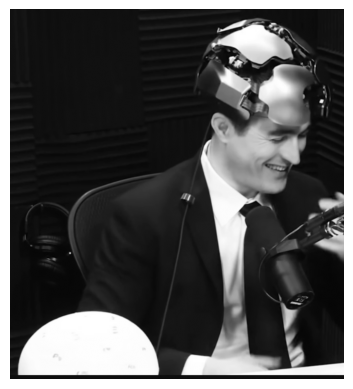

In [4]:
lex_human_laughter_only_gray_np_img = cv2.cvtColor(lex_human_laughter_only_np[0], cv2.COLOR_BGR2GRAY)
plt.imshow(lex_human_laughter_only_gray_np_img, cmap="gray")
lex_human_laughter_only_gray_np_img.shape
plt.axis('off')
plt.show()
# plt.imshow(lex_human_laughter_only_gray_np[0])

### Extract Face Mesh

In [ ]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def extract_landmarks(image_path):
    # Read and process image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)

    # Extract landmarks
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                x, y = landmark.x, landmark.y  # Normalized (0 to 1)
                landmarks.append([x, y])

    if len(landmarks) == 468:  # Ensure full face mesh is detected
        return np.array(landmarks).flatten()  # Convert to 1D array
    else:
        return None  # Skip if face not detected

# Example usage
landmark_vector = extract_landmarks("laughter.jpg")
print(landmark_vector.shape)  # Should be (936,) if all landmarks are found


### Facial Emotion Dataset

In [ ]:
# Custom dataset class
class LaughterDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        landmarks = extract_landmarks(self.image_paths[idx])
        if landmarks is None:
            return None  # Skip if no face detected

        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return landmarks, label

# Load dataset
image_paths = ["laugh1.jpg", "serious1.jpg", "laugh2.jpg"]
labels = [1, 0, 1]  # 1 = laughter, 0 = no laughter

dataset = LaughterDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Facial Emotion Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LaughterCNN(nn.Module):
    def __init__(self):
        super(LaughterCNN, self).__init__()
        self.fc1 = nn.Linear(936, 256)  # 468 x 2 = 936 input features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Binary classification (0 = no laughter, 1 = laughter)
        return x

# Initialize model
model = LaughterCNN()


### Facial Emotion Predictions

In [ ]:
def predict_laughter(image_path, model):
    landmarks = extract_landmarks(image_path)
    if landmarks is None:
        return "No Face Detected"
    
    landmarks = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0)
    model.eval()
    
    with torch.no_grad():
        output = model(landmarks)
        prob = output.item()

    return "Laughter" if prob > 0.5 else "No Laughter"

print(predict_laughter("test_laugh.jpg", model))


## Kernel Neural Image Expert

#### Data Examples

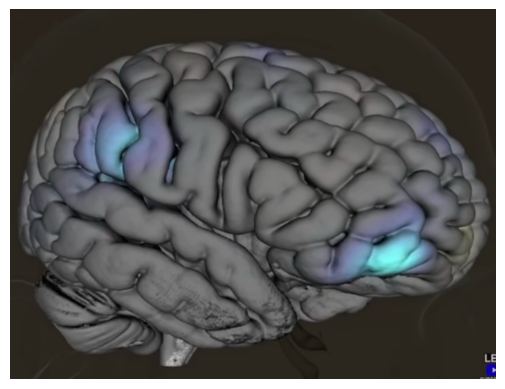

Number of Examples of Laughter: 279


In [12]:
plt.imshow(lex_brain_laughter_only_np[0])
plt.axis('off')
plt.show()
print(f"Number of Examples of Laughter: {len(lex_brain_laughter_only_np)}")

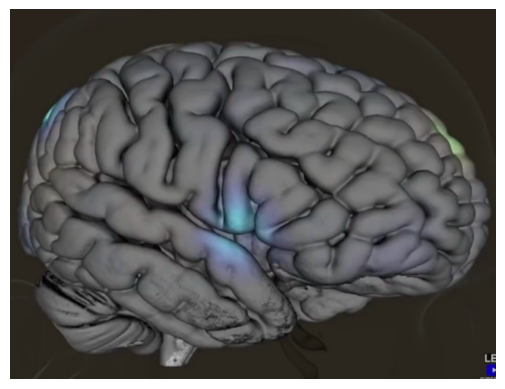

Number of Examples of Non-Laughter: 339


(800, 1050, 3)

In [15]:
plt.imshow(lex_brain_non_laughter_np[0])
plt.axis('off')
plt.show()
print(f"Number of Examples of Non-Laughter: {len(lex_brain_non_laughter_np)}")
lex_brain_non_laughter_np[0].shape

In [ ]:
# Computing the Mean and Variance to Normalize the data:

# Load your dataset
dataset = tv_datasets.ImageFolder(root='your_dataset_path', transform=transforms.ToTensor())

# Create a DataLoader to iterate over the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize variables to compute the mean and std
mean = 0.0
std = 0.0
num_batches = 0

# Iterate over the dataset to compute mean and std
for images, _ in dataloader:
    batch_samples = images.size(0)  # Get the number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Flatten the images
    mean += images.mean(2).sum(0)  # Sum the mean of each image channel
    std += images.std(2).sum(0)    # Sum the std of each image channel
    num_batches += 1

mean /= num_batches  # Average mean over all batches
std /= num_batches    # Average std over all batches

print("Mean:", mean)
print("Std:", std)


In [ ]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Load dataset (Assuming laughter and non-laughter images are in separate folders)
dataset = tv_datasets.ImageFolder(root="/path_to_images", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define CNN Model
class LaughterCNN(nn.Module):
    def __init__(self):
        super(LaughterCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # Binary classification (Laughter vs. Non-Laughter)
    
    def forward(self, x):
        return self.model(x)

# Initialize model
model = LaughterCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


## Audio Laughter Expert

### Extract MFCC

In [ ]:
import librosa
import numpy as np
import torch

def extract_mfcc(audio_path, sr=22050, n_mfcc=40, max_len=50):
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to max_len
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

# Example usage
mfcc_features = extract_mfcc("laughter.wav")
print(mfcc_features.shape)  # (40, 50) -> 40 MFCC features, 50 time steps


### Train CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LaughterCNN(nn.Module):
    def __init__(self):
        super(LaughterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 10 * 12, 128)  # Adjust shape dynamically if needed
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Binary classification
        return x

# Initialize the model
model = LaughterCNN()


### Build MFCC Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MFCCDataset(Dataset):
    def __init__(self, audio_files, labels):
        self.audio_files = audio_files
        self.labels = labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        mfcc = extract_mfcc(self.audio_files[idx])
        mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return mfcc, label

# Example dataset
audio_files = ["laugh1.wav", "serious1.wav", "laugh2.wav"]
labels = [1, 0, 1]  # 1 = laughter, 0 = no laughter

dataset = MFCCDataset(audio_files, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Train Model

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for batch in dataloader:
        mfccs, labels = batch
        labels = labels.unsqueeze(1)  # Reshape for BCELoss

        optimizer.zero_grad()
        outputs = model(mfccs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

print("Training complete!")


### Make Predictions

In [ ]:
def predict_laughter(audio_path, model):
    mfcc = extract_mfcc(audio_path)
    mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(mfcc)
        prob = output.item()

    return "Laughter" if prob > 0.5 else "No Laughter"

print(predict_laughter("test_laugh.wav", model))


## Body Pose Expert

### Extract Pose Body Features

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def extract_pose_landmarks(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_image)

    landmarks = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            x, y, visibility = landmark.x, landmark.y, landmark.visibility
            landmarks.append([x, y, visibility])

    if len(landmarks) == 33:  # Ensure full pose is detected
        return np.array(landmarks).flatten()  # Convert to 1D array
    else:
        return None  # Skip if pose not detected

# Example usage
pose_vector = extract_pose_landmarks("laughter_pose.jpg")
print(pose_vector.shape)  # Should be (99,) if all landmarks are found (33 x 3)


### Laughter Pose CNN

In [ ]:
import torch
import torch.nn as nn

class LaughterPoseCNN(nn.Module):
    def __init__(self):
        super(LaughterPoseCNN, self).__init__()
        self.fc1 = nn.Linear(99, 128)  # 33 x 3 = 99 input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Binary classification (0 = no laughter, 1 = laughter)
        return x

# Initialize model
model = LaughterPoseCNN()


### Laughter Pose Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PoseLaughterDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        landmarks = extract_pose_landmarks(self.image_paths[idx])
        if landmarks is None:
            return None  # Skip if no pose detected

        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return landmarks, label

# Load dataset
image_paths = ["laugh1.jpg", "serious1.jpg", "laugh2.jpg"]
labels = [1, 0, 1]  # 1 = laughter, 0 = no laughter

dataset = PoseLaughterDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Training Laughter Pose Model

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for batch in dataloader:
        if batch is None:
            continue  # Skip invalid samples
        
        landmarks, labels = batch
        labels = labels.unsqueeze(1)  # Reshape for BCELoss

        optimizer.zero_grad()
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

print("Training complete!")


### Making Model Predictions

In [ ]:
def predict_laughter_from_pose(image_path, model):
    landmarks = extract_pose_landmarks(image_path)
    if landmarks is None:
        return "No Pose Detected"
    
    landmarks = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0)
    model.eval()
    
    with torch.no_grad():
        output = model(landmarks)
        prob = output.item()

    return "Laughter" if prob > 0.5 else "No Laughter"

print(predict_laughter_from_pose("test_laughter_pose.jpg", model))


## Training a Mixture of Experts Model Example

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Expert Networks (one for each modality)
class AudioExpert(nn.Module):
    def __init__(self):
        super(AudioExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


class FacialEmotionExpert(nn.Module):
    def __init__(self):
        super(FacialEmotionExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


class BodyPoseExpert(nn.Module):
    def __init__(self):
        super(BodyPoseExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


class NeuralDataExpert(nn.Module):
    def __init__(self):
        super(NeuralDataExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


# Gating Network (Decides how much weight each expert gets)
class GatingNetwork(nn.Module):
    def __init__(self):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(1024, 4)  # 4 experts (one per modality)

    def forward(self, x):
        gate_weights = F.softmax(self.fc(x), dim=1)  # Output weights for each expert
        return gate_weights


# MoE Model that uses Gating Network and Expert Networks
class MixtureOfExperts(nn.Module):
    def __init__(self):
        super(MixtureOfExperts, self).__init__()
        self.audio_expert = AudioExpert()
        self.facial_emotion_expert = FacialEmotionExpert()
        self.body_pose_expert = BodyPoseExpert()
        self.neural_data_expert = NeuralDataExpert()
        self.gating_network = GatingNetwork()
        self.final_fc = nn.Linear(256, 1)
        
        # Final prediction layer for binary output (laughter: 1, not laughter: 0)

    def forward(self, audio, facial_emotion, body_pose, neural_data):
        # Concatenate inputs to pass through the gating network
        combined_input = torch.cat(
            (audio, facial_emotion, body_pose, neural_data), dim=1
        )

        # Get gate weights (importance of each modality)
        gate_weights = self.gating_network(combined_input)

        # Compute the output of each expert
        audio_output = self.audio_expert(audio)
        facial_emotion_output = self.facial_emotion_expert(facial_emotion)
        body_pose_output = self.body_pose_expert(body_pose)
        neural_data_output = self.neural_data_expert(neural_data)

        # Combine the outputs weighted by the gate's output
        weighted_outputs = (
            gate_weights[:, 0].unsqueeze(1) * audio_output
            + gate_weights[:, 1].unsqueeze(1) * facial_emotion_output
            + gate_weights[:, 2].unsqueeze(1) * body_pose_output
            + gate_weights[:, 3].unsqueeze(1) * neural_data_output
        )

        final_output = self.final_fc(weighted_outputs)

        # Sigmoid activation to get probability
        prediction = torch.sigmoid(final_output)

        return prediction


In [ ]:
# Example usage
model = MixtureOfExperts()
audio_data = torch.randn(1, 256)  # Example audio data
facial_emotion_data = torch.randn(1, 256)  # Example facial emotion data
body_pose_data = torch.randn(1, 256)  # Example body pose data
neural_data = torch.randn(1, 256)  # Example neural data

# Make a prediction
prediction = model(audio_data, facial_emotion_data, body_pose_data, neural_data)
print(f"Predicted output: {prediction}")


In [ ]:
# Defining the dataset class
from torch.utils.data import Dataset, DataLoader

class LaughterDataset(Dataset):
    def __init__(self, audio_features, facial_features, body_features, neural_features, labels):
        self.audio_features = audio_features
        self.facial_features = facial_features
        self.body_features = body_features
        self.neural_features = neural_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.audio_features[idx], dtype=torch.float32),
            torch.tensor(self.facial_features[idx], dtype=torch.float32),
            torch.tensor(self.body_features[idx], dtype=torch.float32),
            torch.tensor(self.neural_features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32),
        )


In [ ]:
# Preparing training and validation data
import numpy as np

# Load or generate random data (replace with actual data loading)
num_samples = 1000  # Adjust based on dataset size
audio_features = np.random.randn(num_samples, 256)
facial_features = np.random.randn(num_samples, 256)
body_features = np.random.randn(num_samples, 256)
neural_features = np.random.randn(num_samples, 256)
labels = np.random.randint(0, 2, size=(num_samples, 1))  # Binary labels

# Split into training and validation sets
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

dataset = LaughterDataset(audio_features, facial_features, body_features, neural_features, labels)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Defining the training loop
import torch.optim as optim

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MixtureOfExperts().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for audio, facial, body, neural, label in train_loader:
            audio, facial, body, neural, label = (
                audio.to(device),
                facial.to(device),
                body.to(device),
                neural.to(device),
                label.to(device),
            )

            optimizer.zero_grad()
            output = model(audio, facial, body, neural)
            loss = criterion(output, label)  # Compute loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for audio, facial, body, neural, label in val_loader:
                audio, facial, body, neural, label = (
                    audio.to(device),
                    facial.to(device),
                    body.to(device),
                    neural.to(device),
                    label.to(device),
                )

                output = model(audio, facial, body, neural)
                val_loss += criterion(output, label).item()
                predicted = (output > 0.5).float()  # Convert probability to class (0 or 1)
                correct += (predicted == label).sum().item()
                total += label.size(0)

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}"
        )

# Train for 20 epochs
train_model(model, train_loader, val_loader, epochs=20)


In [ ]:
# Saving the model
# torch.save(model.state_dict(), "moe_laughter_model.pth")

# Loading the model
# model = MixtureOfExperts()
# model.load_state_dict(torch.load("moe_laughter_model.pth"))
# model.to(device)
# model.eval()


In [ ]:
# Making Predictions
# Example input
new_audio = torch.randn(1, 256).to(device)
new_facial = torch.randn(1, 256).to(device)
new_body = torch.randn(1, 256).to(device)
new_neural = torch.randn(1, 256).to(device)

# Get model prediction
with torch.no_grad():
    prediction = model(new_audio, new_facial, new_body, new_neural)
    predicted_label = (prediction > 0.5).float().item()  # Convert to class label

print(f"Predicted label: {predicted_label}")  # 1 for laughter, 0 for no laughter


## Data Representation

    Audio: Convert audio signals into spectrograms or MFCCs (Mel-Frequency Cepstral Coefficients).
    Facial Emotion: Use a facial recognition system (like OpenCV or Dlib) to extract facial landmarks and classify emotional states.
    Body Pose: Use a pose estimation model (like OpenPose or MediaPipe) to extract keypoints of the body.
    Neural Data: Normalize brain activity (e.g., fMRI, EEG) to a standard scale.

2. Model Architecture

The core idea is to create a multi-encoder architecture with modality-specific subnetworks and a fusion layer. Here's how to structure it:
Step 1: Modality-Specific Encoders

Create separate neural networks (like CNNs, RNNs, or Transformers) for each modality. Here's how:

    Audio Encoder: Use a 1D CNN or RNN to process audio features like spectrograms.
    Facial Emotion Encoder: Use a CNN (ResNet, VGG) to process facial emotion features extracted from images.
    Body Pose Encoder: Use a CNN or RNN to process body pose keypoints.
    Neural Data Encoder: Use a simple MLP (Multi-layer Perceptron) or RNN to process neural data like EEG or fMRI.

In [ ]:
non_laughter_audio_data, non_laughter_sample_rate = librosa.load(audio_file_path_non_laughter_train)
IPDAudio(data=non_laughter_audio_data, rate=non_laughter_sample_rate)


In [ ]:

laughter_only_audio_data, laughter_only_sample_rate = librosa.load(audio_file_path_laughter_train)
IPDAudio(data=laughter_only_audio_data, rate=laughter_only_sample_rate)